# Hyperlocation data at _Luxury Bahia Principe Fantasia_

In [3]:
import pandas as pd
import numpy as np

In [4]:
from collections import defaultdict


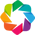

In [5]:
import holoviews as hv
hv.extension('bokeh')

In [6]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
sns.set_style("whitegrid")

In [8]:
# read data from file
source_file = "../../data_sample/hotel_data/2-8-oct-CMX.txt"
hotel = pd.read_csv(source_file, header=None, error_bad_lines=False, warn_bad_lines=False)

# drop meaningless columns
to_drop = [1,2,5,7,8,9,10,11,14,17,18]
hotel = hotel.drop(hotel.columns[to_drop], axis=1)

# give names to remaining columns
columns = ["apmac","big_area","area","ip","timestamp","ssid","clientmac","epoch","vendor"]
hotel.columns = columns

# convert timestamp
hotel["timestamp"] = pd.to_datetime(hotel["timestamp"])

# for the moment we also exclude some other fields
hotel = hotel[["apmac","area","timestamp","clientmac","vendor"]]

In [66]:
# add time aggregations
hotel["date"] = hotel.timestamp.dt.date
hotel["hour"] = hotel.timestamp.dt.hour

In [68]:
# show data sample
hotel.head(3)

apmac   area           timestamp          clientmac   vendor  \
0  84:3d:c6:b7:b5:40  Lobby 2017-10-02 00:04:51  e8:50:8b:a2:cf:a6  Samsung   
1  84:3d:c6:b7:b5:40  Lobby 2017-10-02 00:04:33  e8:50:8b:a2:cf:a6  Samsung   
2  84:3d:c6:b7:b5:40  Lobby 2017-10-02 00:04:05  e8:50:8b:a2:cf:a6  Samsung   

         date  hour  
0  2017-10-02     0  
1  2017-10-02     0  
2  2017-10-02     0

### Timeseries: number of users per day (all hotel)

In [33]:
areas_rank = hotel.groupby("area").clientmac.nunique().sort_values(ascending=False).index

In [43]:
users_per_day = pd.DataFrame({
    "user_cnt":hotel.groupby(["date","area"]).clientmac.nunique()
}).reset_index()

users_per_day_tot = pd.DataFrame({
    "user_cnt":hotel.groupby(["date"]).clientmac.nunique(),
}).reset_index()
users_per_day_tot["area"] = "total"

users_per_day = users_per_day.append(users_per_day_tot, ignore_index=True)
users_per_day["timestamp"] = pd.to_datetime(users_per_day["timestamp"])

In [67]:
users_per_hour = pd.DataFrame({
    "user_cnt":hotel.groupby(["date","hour","area"]).clientmac.nunique()
}).reset_index()

users_per_hour_tot = pd.DataFrame({
    "user_cnt":hotel.groupby(["date","hour"]).clientmac.nunique(),
}).reset_index()
users_per_hour_tot["area"] = "total"

users_per_hour = users_per_hour.append(users_per_hour_tot, ignore_index=True)
#users_per_hour["timestamp"] = pd.to_datetime(users_per_hour["timestamp"])

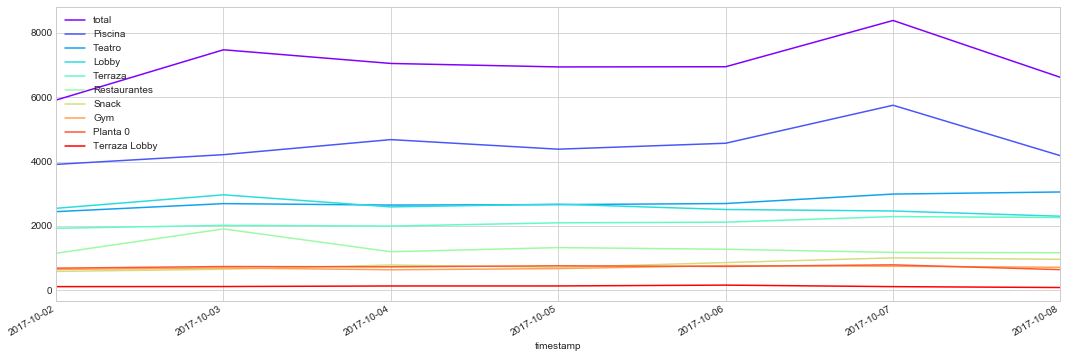

In [78]:
fig, ax = plt.subplots(1,1,figsize=(18,6))
ax.set_prop_cycle('color',plt.cm.rainbow(np.linspace(0,1,len(areas_rank)+1)))

for a in areas_rank.insert(0, 'total'):
    df = users_per_day[users_per_day.area==a]
    df.plot(x="timestamp", ax=ax)

_ = ax.legend(areas_rank.insert(0, 'total'))

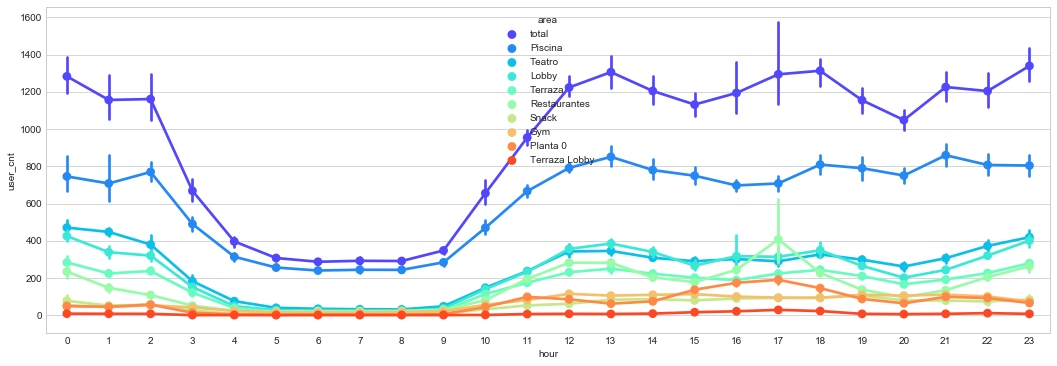

In [229]:
fig, ax = plt.subplots(1,1,figsize=(18,6))
ax.set_prop_cycle('color',plt.cm.rainbow(np.linspace(0,1,len(areas_rank)+1)))

_ = sns.pointplot(x="hour", y="user_cnt", hue="area", ax=ax, palette="rainbow",
              data=users_per_hour, hue_order=areas_rank.insert(0, 'total'))

### How many areas by user
Show distribution of number of different areas visited by user.

**Result**: 60% of users are seen only in one area in the entire week

In [93]:
areas_distr = hotel.groupby("clientmac").area.nunique().values

In [234]:
%%opts Histogram [tools=['hover', 'crosshair'], width=900] Curve [tools=['hover', 'crosshair'], width=900] Spikes [tools=['hover'], width=900]

bins = np.arange(areas_distr.min(),areas_distr.max(),1)
freqs, edges = np.histogram(areas_distr, bins=bins, density=True)

mydata = pd.DataFrame({"areas_cnt":edges[:-1], "CDF":np.cumsum(freqs), "PDF":freqs})

pdf = hv.Histogram((mydata.PDF, mydata.areas_cnt), label="Empirical distribution of number of visited areas by user").redim.label(x="number of visited areas")
cdf = hv.Curve(mydata, kdims="areas_cnt", vdims="CDF")

note = hv.Text(-40,0.02,str("hola"))
note = note.opts(style=dict(text_font_size='8pt', text_color='gray', text_font='Arial'))

(pdf * note).cols(1)

:Overlay
   .Histogram.Empirical_distribution_of_number_of_visited_areas_by_user :Histogram   [x]   (Frequency)
   .Text.I                                                              :Text   [x,y]

### Calculate sequences

In [199]:
# create sequence data frame
seq = hotel.sort_values(by=["clientmac","timestamp"])[["clientmac","timestamp","area"]].reset_index(drop=True)

# island problem
seq["c1"] = seq.groupby(["clientmac"]).cumcount() + 1
seq["prev_area"] = seq.groupby("clientmac").area.shift()
seq["c2"] = seq.groupby(["clientmac","area","prev_area"]).cumcount() + 1
seq.loc[seq.area==seq.prev_area,"island"] = seq.c1 - seq.c2
seq.loc[seq.island.isnull(), "island"] = seq.c1
seq.drop("c1", axis=1, inplace=True)
seq.drop("c2", axis=1, inplace=True)
seq.drop("prev_area", axis=1, inplace=True)

In [201]:
seq.head(20)

clientmac           timestamp          area  island
0   00:00:08:ed:94:1c 2017-10-02 20:15:59       Terraza     1.0
1   00:00:08:ed:94:1c 2017-10-02 20:18:01       Terraza     1.0
2   00:00:08:ed:94:1c 2017-10-02 20:20:01       Terraza     1.0
3   00:00:08:ed:94:1c 2017-10-02 20:30:19       Terraza     1.0
4   00:00:6c:34:35:37 2017-10-05 22:30:38       Terraza     1.0
5   00:03:7f:04:e0:65 2017-10-02 16:18:34       Piscina     1.0
6   00:03:7f:04:e0:65 2017-10-02 16:19:33  Restaurantes     2.0
7   00:03:7f:04:e0:65 2017-10-03 16:08:35       Piscina     3.0
8   00:03:7f:04:e0:65 2017-10-03 16:09:35       Terraza     4.0
9   00:03:7f:04:e0:65 2017-10-05 16:09:01        Teatro     5.0
10  00:03:7f:04:e0:65 2017-10-07 16:44:45  Restaurantes     6.0
11  00:03:ab:13:9f:6f 2017-10-08 10:12:45         Lobby     1.0
12  00:03:ab:13:9f:6f 2017-10-08 10:13:15         Lobby     1.0
13  00:03:ab:13:9f:6f 2017-10-08 10:14:25        Teatro     3.0
14  00:03:ab:13:9f:6f 2017-10-08 10:14:33       Piscina     4.0
15  00:03:ab:64:4b:f1 2017-10-02 10:47:30       Terraza     1.0
16  00:03:ab:64:4b:f1 2017-10-02 10:47:32       Terraza     1.0
17  00:03:ab:64:4b:f1 2017-10-02 12:24:50         Lobby     3.0
18  00:03:ab:64:4b:f1 2017-10-02 15:28:22       Piscina     4.0
19  00:03:ab:64:4b:f1 2017-10-02 15:30:57       Terraza     5.0

## Calculate dwelling times
Dwelling time in an area = how long a user stays in a area.

**Note**: I exclude samples with dwelling times=0, which represent users passing by an area without stopping.

In [237]:
dwellings = pd.DataFrame({
    "arrive": seq.groupby(["clientmac","area","island"]).timestamp.min(),
    "leave" : seq.groupby(["clientmac","area","island"]).timestamp.max()
}).reset_index()
dwellings["dwell_time"] = dwellings.leave - dwellings.arrive
dwellings["dwell_time_seconds"] = dwellings.dwell_time.dt.seconds
dwellings["dwell_time_minutes"] = dwellings.dwell_time.dt.seconds/60

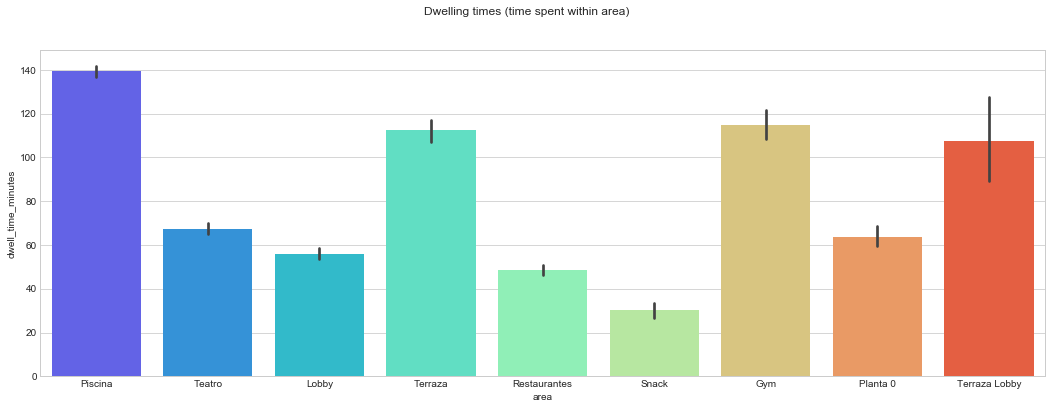

In [239]:
fig, ax = plt.subplots(1,1,figsize=(18,6))
_ = sns.barplot(data=dwellings[dwellings.dwell_time_seconds>0], x="area", y="dwell_time_minutes", 
            ax=ax, order=areas_rank, palette="rainbow")
_ = fig.suptitle("Dwelling times (time spent within area)")

## Study patterns and sequences
Check which are the most popular sequences of areas.

In [634]:
def is_sub(sub, lst):
    ln_sub = len(sub)
    ln_lst = len(lst)
    
    if ln_sub > ln_lst:
        return False
    
    for i in range(ln_lst - ln_sub + 1):
        if all(sub[j] == lst[i+j] for j in range(ln_sub)):
            return True
        
    return False

In [727]:
# generate "clean" sequences (without repetitions)
seq_clean = seq[["clientmac","area"]]
seq_clean = seq_clean.loc[(seq_clean.clientmac.shift() != seq_clean.clientmac)|
                          (seq_clean.area.shift() != seq_clean.area)]

In [728]:
# calculate 
visited_areas = pd.DataFrame({"area_cnt": seq_clean.groupby("clientmac").area.nunique()})
seq_length = pd.DataFrame({"shift_cnt": seq.groupby("clientmac").island.nunique()})

In [729]:
# generate array of sequences that are longer than one
authorized_macs = seq_length[(seq_length.shift_cnt>1)&(seq_length.shift_cnt<12)].index

seq_lists = seq_clean[seq_clean.clientmac.isin(authorized_macs)]\
    .groupby("clientmac").apply(lambda x: x.area.tolist()).values

In [730]:
seq_lists_df = pd.DataFrame({"seq_array": seq_lists})
seq_lists_df["seq"] = seq_lists_df.apply(lambda x: ",".join(x.seq_array), axis=1)

In [731]:
seq_count_df = pd.DataFrame({"cnt":seq_lists_df.groupby(["seq"]).size()}).reset_index()
seq_count_df["seq_array"] = seq_count_df.seq.apply(lambda x: x.split(","))
seq_count_df["seq_len"] = seq_count_df.apply(lambda x: len(x.seq_array), axis=1)

In [734]:
seq_counters = defaultdict(int)

for i, s1 in seq_count_df.iterrows():
    for j, s2 in seq_count_df.iterrows():
        if is_sub(s1.seq_array, s2.seq_array):
            seq_counters[s1.seq] = seq_counters[s1.seq] + s2.cnt      

In [920]:
seq_counters_df = pd.DataFrame.from_dict(seq_counters, orient="index").reset_index()
seq_counters_df.columns = ["sequence","num_of_transitions"]
seq_counters_df["length_of_sequence"] = seq_counters_df.sequence.apply(lambda x: len(x.split(",")))

In [921]:
seq_counters_df.sort_values(by="num_of_transitions",ascending=False).head(30).reset_index(drop=True)

sequence  num_of_transitions  length_of_sequence
0                  Teatro,Piscina                1333                   2
1                  Piscina,Teatro                1254                   2
2                   Terraza,Lobby                 960                   2
3                   Lobby,Terraza                 937                   2
4                   Lobby,Piscina                 865                   2
5                   Piscina,Lobby                 688                   2
6                 Piscina,Terraza                 595                   2
7                 Terraza,Piscina                 590                   2
8                    Lobby,Teatro                 552                   2
9                     Gym,Piscina                 518                   2
10         Piscina,Teatro,Piscina                 511                   3
11                    Piscina,Gym                 502                   2
12                   Teatro,Lobby                 491                   2
13           Restaurantes,Piscina                 469                   2
14                 Terraza,Teatro                 448                   2
15          Terraza,Lobby,Terraza                 439                   3
16            Lobby,Terraza,Lobby                 424                   3
17          Teatro,Piscina,Teatro                 409                   3
18                 Teatro,Terraza                 388                   2
19            Piscina,Gym,Piscina                 353                   3
20                  Snack,Piscina                 319                   2
21                  Piscina,Snack                 297                   2
22           Piscina,Restaurantes                 283                   2
23                Gym,Piscina,Gym                 238                   3
24    Lobby,Terraza,Lobby,Terraza                 208                   4
25             Lobby,Restaurantes                 207                   2
26         Teatro,Piscina,Terraza                 207                   3
27    Terraza,Lobby,Terraza,Lobby                 194                   4
28  Teatro,Piscina,Teatro,Piscina                 194                   4
29           Lobby,Teatro,Piscina                 189                   3

In [933]:
seq_counters_df[seq_counters_df.length_of_sequence>2].sort_values(by="num_of_transitions",ascending=False).head(20).reset_index(drop=True)

sequence  num_of_transitions  length_of_sequence
0          Piscina,Teatro,Piscina                 511                   3
1           Terraza,Lobby,Terraza                 439                   3
2             Lobby,Terraza,Lobby                 424                   3
3           Teatro,Piscina,Teatro                 409                   3
4             Piscina,Gym,Piscina                 353                   3
5                 Gym,Piscina,Gym                 238                   3
6     Lobby,Terraza,Lobby,Terraza                 208                   4
7          Teatro,Piscina,Terraza                 207                   3
8     Terraza,Lobby,Terraza,Lobby                 194                   4
9   Teatro,Piscina,Teatro,Piscina                 194                   4
10           Lobby,Teatro,Piscina                 189                   3
11         Terraza,Teatro,Piscina                 188                   3
12           Piscina,Teatro,Lobby                 182                   3
13         Terraza,Piscina,Teatro                 181                   3
14  Piscina,Teatro,Piscina,Teatro                 179                   4
15           Lobby,Piscina,Teatro                 175                   3
16        Gym,Piscina,Gym,Piscina                 172                   4
17        Piscina,Gym,Piscina,Gym                 172                   4
18          Terraza,Lobby,Piscina                 165                   3
19          Lobby,Terraza,Piscina                 159                   3

## Transition matrix and graphs

In [927]:
edges_df = seq_counters_df[seq_counters_df.length_of_sequence==2].sort_values(by="num_of_transitions", ascending=False).reset_index(drop=True)
edges_df["seq_array"] = edges_df.sequence.apply(lambda x: x.split(","))
edges_df["source"] = edges_df.seq_array.apply(lambda x: x[0])
edges_df["target"] = edges_df.seq_array.apply(lambda x: x[1])

In [928]:
nodes_df = pd.DataFrame({
    "out_degree": edges_df.groupby("source").num_of_transitions.sum(),
    "in_degree": edges_df.groupby("target").num_of_transitions.sum()
})
nodes_df = nodes_df.fillna(0)
nodes_df["degree"] = nodes_df["in_degree"] + nodes_df["out_degree"]

In [929]:
nodes_list = hotel.area.unique()

matrix = []
for node_source in nodes_list:
    row = []
    for node_target in nodes_list:
        weight = edges_df[(edges_df.source==node_source)&(edges_df.target==node_target)].num_of_transitions.values
        if len(weight)==0: weight = 0
        else             : weight = weight[0]
        
        row.append(weight)
    matrix.append(row)
matrix = np.matrix(matrix)

In [930]:
matrix_df = pd.DataFrame(matrix, index=nodes_list, columns=nodes_list)
matrix_df

Lobby  Teatro  Piscina  Restaurantes  Gym  Planta 0  Terraza  \
Lobby              0     552      865           207    0        55      937   
Teatro           491       0     1333            76    9        67      388   
Piscina          688    1254        0           283  502        89      595   
Restaurantes     186     163      469             0   30       114       74   
Gym                0      16      518            27    0         4       20   
Planta 0          50      60       76           117    0         0       28   
Terraza          960     448      590            53   26        16        0   
Snack             22      54      319             9    0         8       18   
Terraza Lobby      0       0        7             0    0         0        0   

               Snack  Terraza Lobby  
Lobby             43              0  
Teatro            64              2  
Piscina          297              6  
Restaurantes      18              9  
Gym                0              0  
Planta 0           4             23  
Terraza           24              0  
Snack              0              0  
Terraza Lobby      0              0

In [1003]:
%opts HeatMap [width=900 height=600 tools=['hover', 'crosshair'] xaxis=None]
hm = hv.HeatMap(((nodes_list, nodes_list, matrix_df)))
hm = hm.redim.label(y="source", x="destination", z="transition_cnt")
hm.relabel("Pair-wise transitions")

:HeatMap   [x,y]   (z)

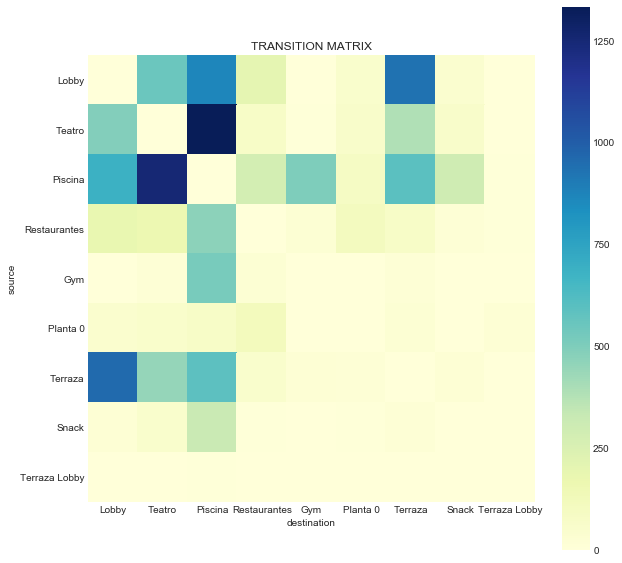

In [931]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
_ = sns.heatmap(matrix_df, square=True, cmap="YlGnBu", ax=ax)
_ = ax.set(xlabel="destination", ylabel="source", title="TRANSITION MATRIX")

In [1002]:
%opts Nodes Graph [width=600 height=600 xaxis=None yaxis=None]

def get_graph(weight=100):
    
    filt_df = edges_df[edges_df.num_of_transitions>=weight]
    s = filt_df.source.values
    t = filt_df.target.values
    c = filt_df.num_of_transitions.values
    g = hv.Graph(((s,t,c),),vdims="weight").opts(plot=dict(inspection_policy='edges'))
    
    return g.edgepaths * g.nodes

hv.HoloMap({i: get_graph(i) for i in range(0, 1400, 100)},
           kdims='Weight filters').redim.range(x=(-1.2, 1.2), y=(-1.2, 1.2))

:HoloMap   [Weight filters]
   :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .Nodes.I     :Nodes   [x,y,index]

In [10]:
import re

random_mac_cnt = 0
clean_list = []

# create a list of "clean" MACs and count the random ones
for mac in hotel.clientmac.unique():
    is_random = False
    for pattern in ["da:a1:19","92:68:c3"]:
        if re.compile(pattern).match(mac):
            is_random = True
    if(is_random):
        random_mac_cnt = random_mac_cnt + 1
    else:
        clean_list.append(mac)

# print findings
print("Total number of MACs:\t{:>6} (100.00%)".format(hotel.clientmac.nunique()))
print("Random MAC found:\t{:>6} ({:6.2f}%)".format(random_mac_cnt,random_mac_cnt*100/hotel.clientmac.nunique()))
print("The other (ok) MACs:\t{:>6} ({:6.2f}%)".format(len(clean_list), len(clean_list)*100/hotel.clientmac.nunique()))

Total number of MACs:	 27055 (100.00%)
Random MAC found:	     0 (  0.00%)
The other (ok) MACs:	 27055 (100.00%)


In [9]:
hotel

apmac          area           timestamp  \
0        84:3d:c6:b7:b5:40         Lobby 2017-10-02 00:04:51   
1        84:3d:c6:b7:b5:40         Lobby 2017-10-02 00:04:33   
2        84:3d:c6:b7:b5:40         Lobby 2017-10-02 00:04:05   
3        84:3d:c6:b7:b5:40         Lobby 2017-10-02 00:03:51   
4        84:3d:c6:b7:b5:40         Lobby 2017-10-02 00:03:34   
5        84:3d:c6:b7:b5:40        Teatro 2017-10-02 00:03:05   
6        84:3d:c6:b7:b5:40         Lobby 2017-10-02 00:01:49   
7        84:3d:c6:b7:b5:40        Teatro 2017-10-02 00:00:51   
8        84:3d:c6:b7:b5:40        Teatro 2017-10-02 00:00:22   
9                      NaN       Piscina 2017-10-02 00:04:05   
10                     NaN       Piscina 2017-10-02 00:03:55   
11       84:3d:c6:72:9e:b0       Piscina 2017-10-02 00:04:57   
12       84:3d:c6:72:9e:b0         Lobby 2017-10-02 00:04:51   
13       84:3d:c6:72:9e:b0       Piscina 2017-10-02 00:04:43   
14       84:3d:c6:72:9e:b0       Piscina 2017-10-02 00:04:35   
15       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:04:27   
16       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:04:14   
17       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:04:11   
18       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:04:01   
19       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:03:59   
20       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:03:55   
21       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:03:45   
22       00:d7:8f:2b:93:d0         Lobby 2017-10-02 00:03:37   
23       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:03:32   
24       00:d7:8f:2b:93:d0        Teatro 2017-10-02 00:02:53   
25       00:d7:8f:2b:93:d0         Lobby 2017-10-02 00:02:43   
26       00:d7:8f:2b:93:d0         Lobby 2017-10-02 00:02:31   
27       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:02:11   
28       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:02:07   
29       00:d7:8f:2b:93:d0       Piscina 2017-10-02 00:01:43   
...                    ...           ...                 ...   
3679004                NaN       Piscina 2017-10-08 23:51:27   
3679005                NaN       Piscina 2017-10-08 23:50:43   
3679006                NaN       Piscina 2017-10-08 23:52:51   
3679007  00:a2:ee:e2:64:00       Piscina 2017-10-08 23:52:51   
3679008  84:b2:61:af:f1:90           Gym 2017-10-08 23:54:27   
3679009  84:b2:61:af:f1:90       Piscina 2017-10-08 23:53:57   
3679010  00:d7:8f:2b:94:80       Piscina 2017-10-08 23:53:21   
3679011  00:d7:8f:2b:94:80       Piscina 2017-10-08 23:52:55   
3679012  00:d7:8f:2b:94:80       Piscina 2017-10-08 23:52:23   
3679013  00:d7:8f:2b:94:80       Piscina 2017-10-08 23:51:53   
3679014  00:d7:8f:2b:94:80       Piscina 2017-10-08 23:51:09   
3679015  00:d7:8f:2b:94:80       Piscina 2017-10-08 23:51:03   
3679016  00:d7:8f:2b:94:80       Piscina 2017-10-08 23:50:59   
3679017  00:a2:ee:e2:63:30       Piscina 2017-10-08 23:50:27   
3679018  00:a2:ee:e2:64:00       Piscina 2017-10-08 23:50:09   
3679019                NaN       Piscina 2017-10-08 23:52:51   
3679020                NaN           Gym 2017-10-08 23:51:53   
3679021                NaN       Piscina 2017-10-08 23:50:51   
3679022                NaN       Piscina 2017-10-08 23:51:55   
3679023  84:3d:c6:73:10:a0  Restaurantes 2017-10-08 23:54:24   
3679024  84:3d:c6:73:10:a0  Restaurantes 2017-10-08 23:53:39   
3679025  84:3d:c6:73:10:a0  Restaurantes 2017-10-08 23:52:09   
3679026  84:3d:c6:73:10:a0  Restaurantes 2017-10-08 23:51:24   
3679027  84:3d:c6:73:10:a0  Restaurantes 2017-10-08 23:50:38   
3679028  84:3d:c6:95:f3:10  Restaurantes 2017-10-08 23:52:05   
3679029                NaN       Piscina 2017-10-08 23:50:27   
3679030  84:3d:c6:72:9e:b0         Lobby 2017-10-08 23:51:27   
3679031  84:3d:c6:72:9e:b0         Lobby 2017-10-08 23:50:51   
3679032  84:3d:c6:b7:b5:40         Lobby 2017-10-08 23:50:43   
3679033  84:3d:c6:73:3e:b0  Restaurantes 2017-10-08 23:52:18   

                 clientmac                          